In [1]:
import numpy as np

from keras.optimizers import SGD
from keras.utils import np_utils
import GPyOpt

import load_mnist
import plot_utils

np.random.seed(1)

Using Theano backend.
/Users/inesalmeida/work/02901_DTU/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load Data

In [2]:
X_train, y_train = load_mnist.load_train()
X_val, y_val, X_test, y_test = load_mnist.split_val_test(load_mnist.load_test())

Loaded 60000 patterns with 784 features.
Loaded 10000 patterns with 784 features.


### Visualize some examples

In [3]:
%matplotlib inline

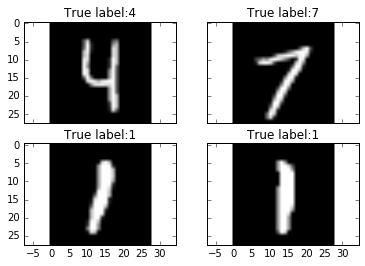

In [4]:
plot_utils.plot_a_few(X_train, y_train)

### Transform Output

In [5]:
NUM_CLASSES = 10

y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
print X_train.shape, y_train.shape
y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

(60000, 784) (60000, 10)


## Part 2: Time Sensitive Optimization
We use a Multilayer Perceptron. We want to estimate the most adequate training hyperparameters in the shortest amount of time.

### Train a Basic Multilayer Perceptron for Illustration

In [6]:
from multilayer_perceptron import build_model

In [7]:
BATCH_SIZE = 10
NUM_EPOCHS = 12

# Build the model (ie the architecture)
model = build_model(num_hidden=32)

# Pick cost function, optimizer, metric
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

# Train
model.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=NUM_EPOCHS,
          verbose=1, validation_data=(X_val, y_val))

Train on 60000 samples, validate on 2000 samples
Epoch 1/12
60000/60000 [==============================] - 16s - loss: 1.4663 - acc: 0.7250 - val_loss: 0.6553 - val_acc: 0.8460
Epoch 2/12
60000/60000 [==============================] - 35s - loss: 0.9720 - acc: 0.8611 - val_loss: 0.5329 - val_acc: 0.8830
Epoch 3/12
60000/60000 [==============================] - 24s - loss: 0.8724 - acc: 0.8772 - val_loss: 0.4891 - val_acc: 0.8945
Epoch 4/12
60000/60000 [==============================] - 27s - loss: 0.8192 - acc: 0.8868 - val_loss: 0.4759 - val_acc: 0.8960
Epoch 5/12
60000/60000 [==============================] - 22s - loss: 0.7896 - acc: 0.8919 - val_loss: 0.4613 - val_acc: 0.8990
Epoch 6/12
60000/60000 [==============================] - 21s - loss: 0.7672 - acc: 0.8953 - val_loss: 0.4513 - val_acc: 0.9055
Epoch 7/12
60000/60000 [==============================] - 24s - loss: 0.7514 - acc: 0.8995 - val_loss: 0.4455 - val_acc: 0.9065
Epoch 8/12
60000/60000 [==============================]

In [8]:
def score(model, X, y):
    s = model.evaluate(X, y, verbose=0)
    print 'Score:', s[0], 'Accuracy:', s[1]
    
print 'Train',
score(model, X_train, y_train)
print 'Validation',
score(model, X_val, y_val)
print 'Test',
score(model, X_test, y_test)

Train Score: 0.432463565461 Accuracy: 0.909766666667
Validation Score: 0.426930578232 Accuracy: 0.9095
Test Score: 0.431588355899 Accuracy: 0.910375


### The Bayesian Optimization Problem
Following the example in [Snoek, Larochelle and Adams (2012)](https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms) for the Logistic Regression model, we want to optimize the following parameters:

* batch size (integer between 20 and 2000)
* L2 regularization parameter (between 0 and 1)
* learning rate (between 0 and 1)
* number of learning epochs (between 5 and 200)
* number of hidden layers (between 16 and 1024)

It is clear some of these parameters affect the time it takes to train the model. With this in mind, we chose to run the Bayesian Optimization taking into consideration the Improvement per Second.

In [13]:
def f(p):
    # p = (l2_coef, learning_rate, num_epochs, batch_size)
    l2_coef = p[0, 0]
    # learning rate does not strongly influence adadelta
    # learning_rate = p[0, 1]
    num_epochs = int(p[0, 1])
    batch_size = int(p[0, 2])

    # Build Model
    m = build_model(num_hidden=32, l2_coef=l2_coef)
    
    # Build custom Optimizer
    # Use this instead of 'adadelta' to optimize on learning rate
    # be warned, however, that convergence is much slower.
    # sgd = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
    
    # Pick cost function, optimizer, metric
    m.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
    # Train
    m.fit(X_train, y_train, batch_size=batch_size, nb_epoch=num_epochs,
          verbose=0, validation_data=(X_val, y_val))

    score = m.evaluate(X_test, y_test, verbose=0)
    
    # For progress tracking
    print "l2: {0:.3f}, \tnepoch: {1:d},\tbatch: {2:d}\t".format(
        l2_coef, num_epochs, batch_size),
    print 'score:', score[0], 'test acc:', score[1]
    
    # Return the score on the test set
    return score[0]

In [14]:
# Define the problem bounds and budget
# Domains:
# l2_coef in [0., 1.]
# learning_rate in { 1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1. }
# num_epochs between 5 and 50
# batch_size approximately between 20 and 2000

bounds = [{ 'name': 'l2_coef',       'type': 'continuous', 'domain': (0., 1.) },
          #{ 'name': 'learning_rate', 'type': 'discrete',   'domain': tuple(np.logspace( -6,   0, 7)) },
          { 'name': 'num_epochs',    'type': 'discrete',   'domain': tuple(np.linspace(5, 50, 6, dtype=int)) },
          { 'name': 'batch_size',    'type': 'discrete',   'domain': tuple(np.logspace(1.30, 3.3, 5, dtype=int)) }]

In [15]:
# Notes:
# log10(5) ~= 0.699
# log10(12) ~= 1.08
# log10(20) ~= 1.30
# log10(50) ~= 1.69
# log10(200) ~= 2.30
# log10(2000) ~= 3.30

In [16]:
# Initialize the problem
np.random.seed(123)
myBopt = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds,
                                             #cost_withGradients='evaluation_time',
                                             initial_design_numdata=5,
                                             acquisition_type='EI',
                                             exact_feval = True)

l2: 0.696, 	nepoch: 41,	batch: 199	score: 2.01743796301 test acc: 0.623625
l2: 0.286, 	nepoch: 14,	batch: 1995	score: 1.46769842958 test acc: 0.841375
l2: 0.227, 	nepoch: 32,	batch: 19	score: 1.57774285746 test acc: 0.845
l2: 0.551, 	nepoch: 23,	batch: 19	score: 1.94718215895 test acc: 0.723125
l2: 0.719, 	nepoch: 41,	batch: 63	score: 2.04563989496 test acc: 0.620875


In [17]:
# Run the optimization
max_iter = 15    # evaluation budget
max_time = 7200  # time budget (2hours)
eps      = 10e-6 # Minimum allows distance between the last two observations

myBopt.run_optimization(max_iter, max_time, eps)  

l2: 0.485, 	nepoch: 14,	batch: 1995	score: 1.64798174429 test acc: 0.793875
l2: 0.101, 	nepoch: 14,	batch: 1995	score: 1.13282688093 test acc: 0.88025
l2: 0.000, 	nepoch: 14,	batch: 1995	score: 0.560397187233 test acc: 0.875125
l2: 0.800, 	nepoch: 5,	batch: 1995	score: 1.52032503128 test acc: 0.73225
l2: 0.800, 	nepoch: 23,	batch: 1995	score: 1.92927456522 test acc: 0.802
l2: 0.192, 	nepoch: 5,	batch: 19	score: 1.51168654251 test acc: 0.85075
l2: 0.192, 	nepoch: 14,	batch: 19	score: 1.4785912447 test acc: 0.84475
l2: 1.000, 	nepoch: 14,	batch: 19	score: 2.10282680511 test acc: 0.511625
l2: 1.000, 	nepoch: 5,	batch: 19	score: 2.10246311951 test acc: 0.49125
l2: 0.000, 	nepoch: 5,	batch: 1995	score: 0.900760876179 test acc: 0.815125
l2: 0.265, 	nepoch: 5,	batch: 1995	score: 1.31638146114 test acc: 0.770375
l2: 0.192, 	nepoch: 5,	batch: 63	score: 1.49245299864 test acc: 0.8455
l2: 1.000, 	nepoch: 5,	batch: 63	score: 2.12266847229 test acc: 0.61025
l2: 0.192, 	nepoch: 5,	batch: 199	score: 

In [18]:
# Print the Optimum
print 'x_opt:', myBopt.x_opt
print 'f(x_opt):', myBopt.fx_opt

x_opt: [    0.    14.  1995.]
f(x_opt): [ 0.56039719]


In [19]:
# Plot Expected Improvement
myBopt.plot_acquisition()

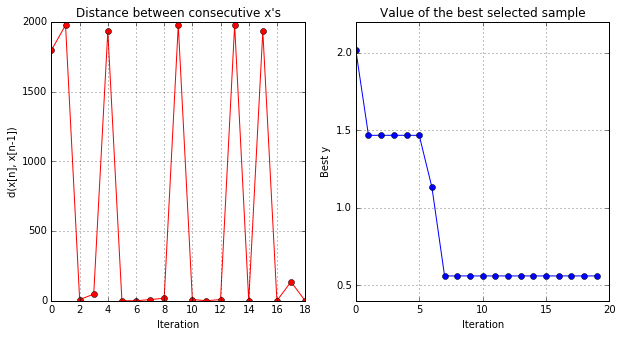

In [20]:
# Convergence
myBopt.plot_convergence()

In [21]:
# Initialize the problem
np.random.seed(123)
myBopt2 = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds,
                                             #cost_withGradients='evaluation_time',
                                             initial_design_numdata=5,
                                             acquisition_type='EI',
                                             exact_feval = True)

# Run the optimization
max_iter = 45    # evaluation budget
max_time = 7200  # time budget (2hours)
eps      = 10e-6 # Minimum allows distance between the last two observations

myBopt2.run_optimization(max_iter, max_time, eps)  

l2: 0.696, 	nepoch: 41,	batch: 199	score: 2.01743796301 test acc: 0.623625
l2: 0.286, 	nepoch: 14,	batch: 1995	score: 1.46769842958 test acc: 0.841375
l2: 0.227, 	nepoch: 32,	batch: 19	score: 1.57774285746 test acc: 0.845
l2: 0.551, 	nepoch: 23,	batch: 19	score: 1.94718215895 test acc: 0.723125
l2: 0.719, 	nepoch: 41,	batch: 63	score: 2.04563989496 test acc: 0.620875
l2: 0.485, 	nepoch: 14,	batch: 1995	score: 1.64798174429 test acc: 0.793875
l2: 0.101, 	nepoch: 14,	batch: 1995	score: 1.13282688093 test acc: 0.88025
l2: 0.000, 	nepoch: 14,	batch: 1995	score: 0.560397187233 test acc: 0.875125
l2: 0.800, 	nepoch: 5,	batch: 1995	score: 1.52032503128 test acc: 0.73225
l2: 0.800, 	nepoch: 23,	batch: 1995	score: 1.92927456522 test acc: 0.802
l2: 0.192, 	nepoch: 5,	batch: 19	score: 1.51168654251 test acc: 0.85075
l2: 0.192, 	nepoch: 14,	batch: 19	score: 1.4785912447 test acc: 0.84475
l2: 1.000, 	nepoch: 14,	batch: 19	score: 2.10282680511 test acc: 0.511625
l2: 1.000, 	nepoch: 5,	batch: 19	scor

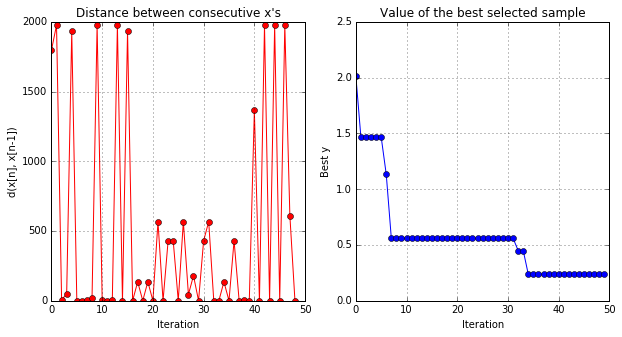

In [23]:
myBopt2.plot_convergence()